# plot-distributions-post-partition
3.2.23

Want to make plots of the distributions of the train/validation/test set fractions
following the partition. This will hopefully become a supplementary figure in the manuscript.

Right now doing this for the SMTG DIA data. Is that the best choice? Probably justifiable either way. 

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# my modules
sys.path.append('../../../bin/')
import utils

# plotting templates
sns.set(context="talk", style="ticks") 
pal = sns.color_palette()

#### Configs

In [2]:
# partitioning params
val_frac = 0.25
test_frac = 0.0
# setting this to 0 ensures that no peptides will be filtered out
min_present = 0     # during partitioning
q_anchor=0.35  # these three for MNAR partition 
t_std=0.6
brnl_prob=0.7

# NMF training params
batch_size = 64

# the random number generator
rng = np.random.default_rng(seed=18)

# the random state for the partition
split_rand_state = 18

#### Read in the DIA AD data

In [3]:
# read in 
cond1_df = pd.read_csv("path/to/the/data")
cond2_df = pd.read_csv("path/to/the/data")

# get the list of peptide IDs, or rather transition group IDs
    # these will be the same for the two datasets
peptide_ids = np.array(cond1_df["pids"])

# now remove the peptide ID columns
to_remove = ["pids"]
cond1_df = cond1_df.drop(to_remove, axis=1)
cond2_df = cond2_df.drop(to_remove, axis=1)

# convert to numpy arrays
cond1_quants = np.array(cond1_df)
cond2_quants = np.array(cond2_df)

print("condition 1 quants: ", cond1_quants.shape)
print("condition 2 quants: ", cond2_quants.shape)

condition 1 quants:  (32614, 9)
condition 2 quants:  (32614, 9)


#### Combine two conditions into a single matrix

In [4]:
# create the combined matrix, to use for imputation 
comb_quants = np.concatenate([cond1_quants, cond2_quants], axis=1)

# should we maybe exponentiate these
# comb_quants = np.exp(comb_quants)

#### Partition
With either MCAR or MNAR

In [11]:
# MCAR partition 
train, val, test = util_functions.split(
                                    comb_quants, 
                                    val_frac=val_frac,
                                    test_frac=test_frac, 
                                    min_present=min_present,
                                    random_state=split_rand_state,
)
# MNAR partition 
# train, val = util_functions.MNAR_partition_thresholds_matrix(
#                                     comb_quants, 
#                                     q_anchor=q_anchor, 
#                                     t_std=t_std, 
#                                     brnl_prob=brnl_prob, 
#                                     min_pres=min_present,
#                                     rand_state=split_rand_state,
# )

#### Get the missingness fractions

In [12]:
orig_mv_frac = np.count_nonzero(np.isnan(comb_quants)) / comb_quants.size
train_mv_frac = np.count_nonzero(np.isnan(train)) / train.size
val_mv_frac = np.count_nonzero(np.isnan(val)) / val.size

print("mv frac original: ", np.around(orig_mv_frac, decimals=3))
print("mv frac train: ", np.around(train_mv_frac, decimals=3))
print("mv frac validation: ", np.around(val_mv_frac, decimals=3))

mv frac original:  0.0
mv frac train:  0.25
mv frac validation:  0.75


#### Plot the distributions of the partitions

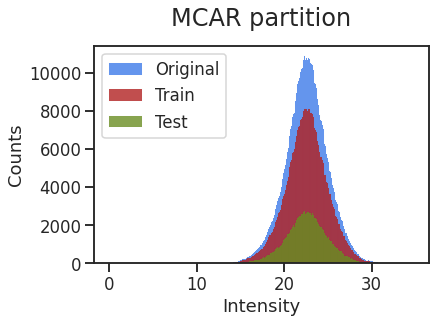

In [14]:
# flatten
quants_rav = comb_quants.ravel()
train_rav = train.ravel()
val_rav = val.ravel()

# get the present values from the original matrix
p_quants_nans = np.isnan(quants_rav)
p_quants_present = quants_rav[~p_quants_nans]

# get present values from the training matrix
train_nans = np.isnan(train_rav)
train_present = train_rav[~train_nans]

# get present values from the validation matrix
val_nans = np.isnan(val_rav)
val_present = val_rav[~val_nans]

# for logged quants
quants_max = np.max(p_quants_present)
quants_min = np.min(p_quants_present)
bins_range = np.arange(0, quants_max, 0.1)

# for non-logged quants
# quants_min = np.quantile(p_quants_present, 0.1)
# quants_max = np.quantile(p_quants_present, 0.7)
# bins_range = np.arange(0, quants_max, 1e9)

plt.figure()
plt.hist(p_quants_present, density=False, bins=bins_range, linewidth=0.01,
         color='cornflowerblue', edgecolor='cornflowerblue', alpha=1.0, label="Original")
plt.hist(train_present, density=False, bins=bins_range, linewidth=0.01, 
         color='firebrick', edgecolor='firebrick', alpha=0.8, label="Train")
plt.hist(val_present, density=False, bins=bins_range, linewidth=0.01,
        color='olivedrab', edgecolor='olivedrab', alpha=0.8, label="Test")

plt.minorticks_off()

plt.legend()
plt.title("MCAR partition", pad=20, size=24)
plt.xlabel("Intensity")
plt.ylabel("Counts")

# plt.savefig(
#     "../logs/partition-distributions-MCAR-0.25valid1.png", dpi=250, bbox_inches="tight"
# )